# Scatter matrix

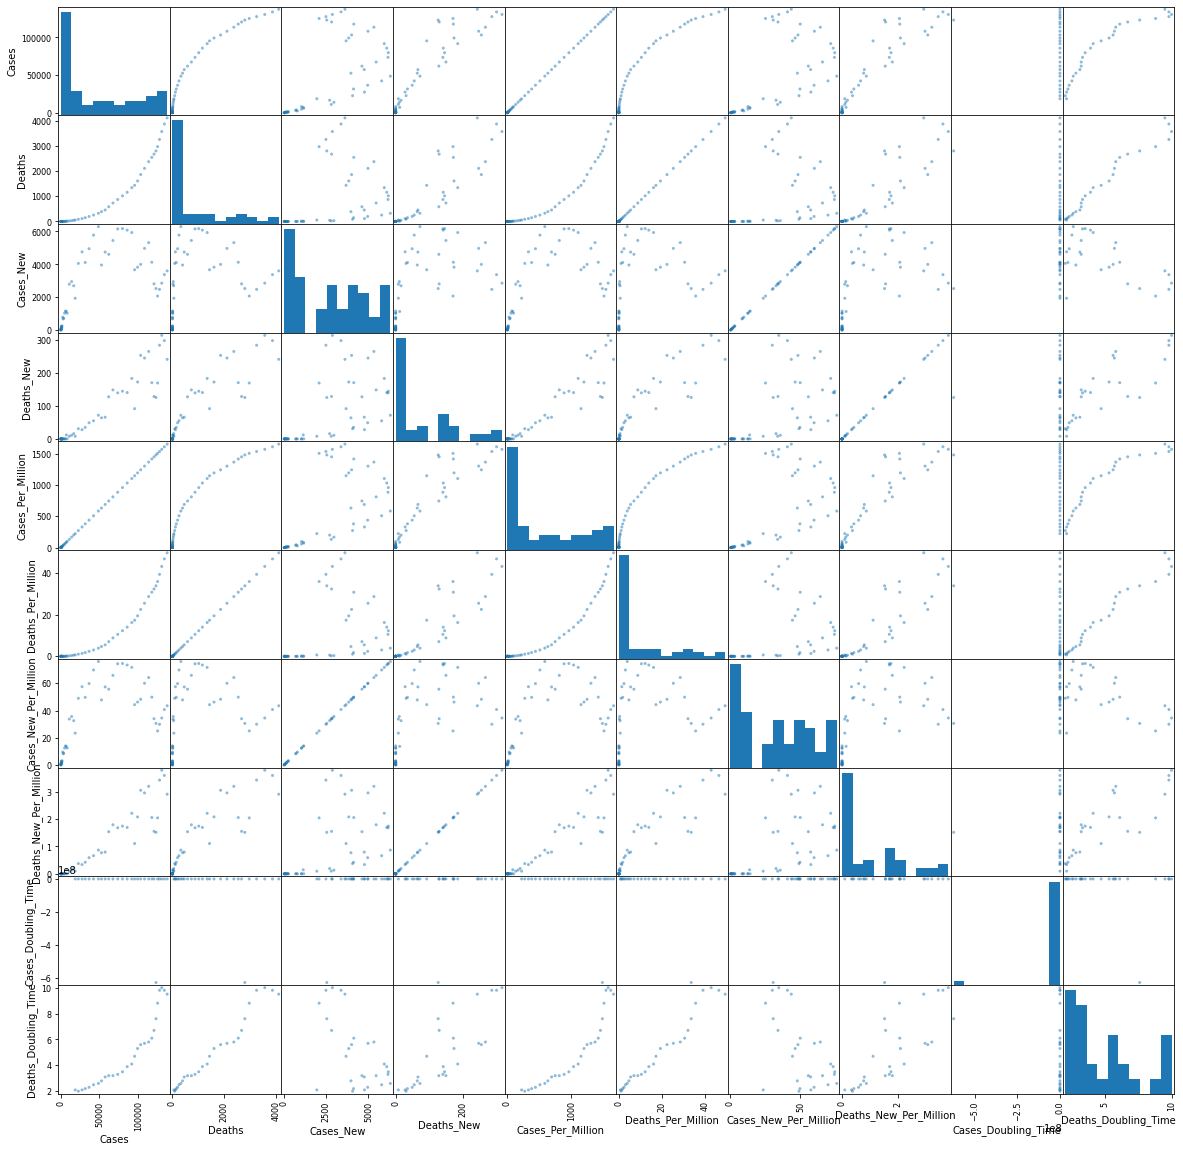

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

area = 'DE-total'
de = entorb.to_dataframe(area)
ax = pd.plotting.scatter_matrix(de, figsize=(20,20))

# R²

In [2]:
corr = de.corr()**2
corr.style.background_gradient(cmap='Blues')

,Cases,Deaths,Cases_New,Deaths_New,Cases_Per_Million,Deaths_Per_Million,Cases_New_Per_Million,Deaths_New_Per_Million,Cases_Doubling_Time,Deaths_Doubling_Time
Cases,1.000000,0.883366,0.383161,0.879028,1.000000,0.883366,0.383164,0.879037,0.041777,0.850837
Deaths,0.883366,1.000000,0.132122,0.822642,0.883366,1.000000,0.132123,0.822673,0.037556,0.964271
Cases_New,0.383161,0.132122,1.000000,0.336286,0.383161,0.132122,1.000000,0.336218,0.071011,0.323118
Deaths_New,0.879028,0.822642,0.336286,1.000000,0.879028,0.822644,0.336289,1.000000,0.001731,0.684164
Cases_Per_Million,1.000000,0.883366,0.383161,0.879028,1.000000,0.883366,0.383164,0.879037,0.041777,0.850837
Deaths_Per_Million,0.883366,1.000000,0.132122,0.822644,0.883366,1.000000,0.132123,0.822675,0.037554,0.964270
Cases_New_Per_Million,0.383164,0.132123,1.000000,0.336289,0.383164,0.132123,1.000000,0.336220,0.071012,0.323113
Deaths_New_Per_Million,0.879037,0.822673,0.336218,1.000000,0.879037,0.822675,0.336220,1.000000,0.001726,0.684211
Cases_Doubling_Time,0.041777,0.037556,0.071011,0.001731,0.041777,0.037554,0.071012,0.001726,1.000000,0.037991
Deaths_Doubling_Time,0.850837,0.964271,0.323118,0.684164,0.850837,0.964270,0.323113,0.684211,0.037991,1.000000


# Deaths formula:

Deaths = 
               2
2.615e-07 Cases - 0.008474 Cases + 43.94


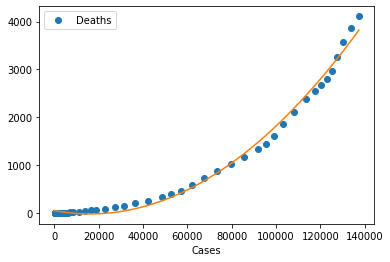

In [3]:
import numpy as np
coefs = np.polyfit(x=de['Cases'], y=de['Deaths'], deg=2)
de.plot(kind='line', x='Cases', y='Deaths', linestyle='', marker='o')
poly = np.poly1d(coefs, variable='Cases')
plt.plot(de['Cases'], poly(de['Cases']))
print("Deaths = ")
print(poly)